In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import torch
import matplotlib.pyplot as plt

import inference.scheduler
from inference.distribution import Gaussian, GaussianMixture
from inference.sde import OU, EulerMaruyamaSimulator, LangevinDynamics

In [3]:
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from inference.distribution import Density
from inference.simulator import Simulator

def plot_trajectories_1d(x0: torch.Tensor, 
                         simulator: Simulator, 
                         timesteps: torch.Tensor, 
                         true_density: Density,
                         plot_less_steps: bool = True):
    """
    Plots 1D trajectories over time and compares final values to a theoretical distribution.

    Args:
        - x0: initial state at time timesteps[0], shape (batch_size, dim)
        - simulator: simulator object with method `simulate_with_trajectory`
        - timesteps: timesteps for simulation, shape (num_timesteps,)
        - true_density: theoretical density object with method `log_density`
        - plot_less_steps: if True, plots a reduced number of trajectories for clarity

    Returns:
        - None (displays a matplotlib plot with simulated trajectories and final distribution)
    """
    ### Initalize figure
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(1, 4, width_ratios=[4, 0.15, 0.05, 1], wspace=0.05)
   

    ### Trajectories plot (Left Plot)
    ax_main = fig.add_subplot(gs[0])
    ax_main.set_title('Trajectories')
    ax_main.set_xlabel(r'Time ($t$)', fontsize=14)
    ax_main.set_ylabel(r'$X_t$', fontsize=14)
    ax_main.grid(True)
    
    # Simulate Trajectories
    trajectories = simulator.simulate_with_trajectory(x0, timesteps) # Shape (batch_size, num_timesteps, dim)
    final_values = trajectories[:, -1, 0].detach().cpu().numpy() # Final values of the trajectories

    # Plot less steps?
    if plot_less_steps and trajectories.shape[0] > 200:
        n_steps = 200
        n = trajectories.shape[0]
        indices = [round(i * (n - 1) / (n_steps - 1)) for i in range(n_steps)]
        trajectories = trajectories[:, indices, :] # Shape (n_steps, num_timesteps, dim)
        timesteps = timesteps[indices]

    alpha = 0.3 # Make `alpha` * 100% transparent
    for i in range(trajectories.shape[0]):
        ax_main.plot(timesteps.cpu(), trajectories[i, :, 0].detach().cpu(), alpha=alpha)

    ### Limiting / Final Distribution Plot (Right Plot)
    ax_hist = fig.add_subplot(gs[3], sharey=ax_main)
    ax_hist.set_title('Final Distribution')
    ax_hist.hist(final_values, bins=40, orientation='horizontal', density=True, color='gray', alpha=0.7)
    ax_hist.tick_params(labelleft=False)
    ax_hist.set_xlabel('Freq', fontsize=12)

    # Get contour of true plot
    y_min, y_max = ax_main.get_ylim()
    y_vals = torch.linspace(y_min, y_max, 500).unsqueeze(1)
    with torch.no_grad():
        log_probs = true_density.log_density(y_vals)
        probs = torch.exp(log_probs).squeeze().cpu().numpy()
    ax_hist.plot(probs, y_vals.squeeze().cpu().numpy(), 'r--', linewidth=2, label='Theoretical PDF')

    plt.tight_layout()


# Testing

### SDE Solver

100%|██████████| 999/999 [00:00<00:00, 8406.89it/s]
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_82873/2289741746.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


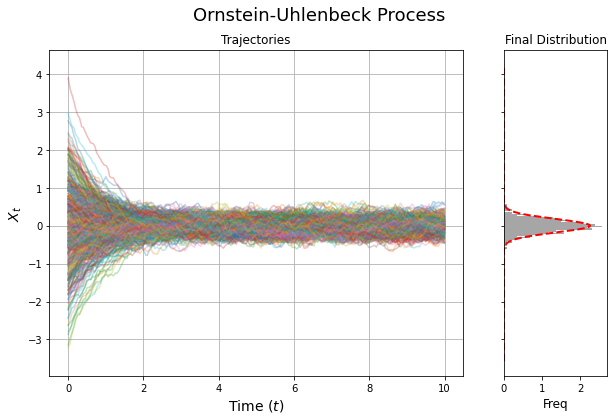

In [4]:
theta = 1.0
sigma = 0.25
sde = OU(theta=theta, sigma=sigma)
simulator = EulerMaruyamaSimulator(sde=sde)
true_density = Gaussian(
    mean = torch.tensor([0.0]), 
    cov = sigma**2 / (2 * theta) * torch.eye(1) # Limiting distribution from OU process
)

# Simulator Settings
num_trials = 500
num_steps = 1000
tf = 20.0

x0 = torch.randn((num_trials,1))
ts = torch.linspace(0, tf, num_steps)

# Visualization
plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
plt.suptitle('Ornstein-Uhlenbeck Process', fontsize=18)
plt.show()

# Langevin Simulator

In langevin dynamics, you input a score $s(x) = \nabla_x \log p(x)$, and the limiting distribution will look like $p(x)$

100%|██████████| 1999/1999 [00:03<00:00, 558.81it/s]
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_82873/2289741746.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


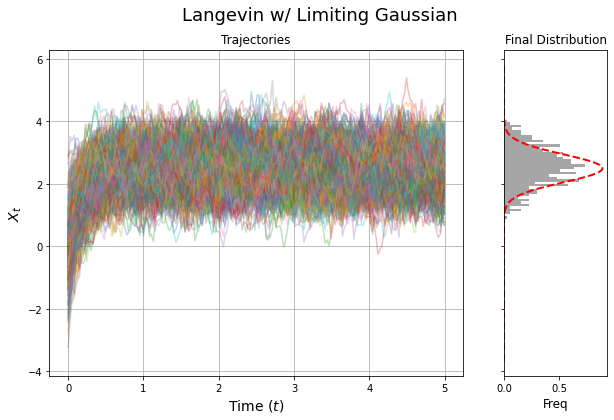

In [7]:
true_density = Gaussian(
    mean = torch.tensor([2.5]), 
    cov = 0.2 * torch.eye(1)
)
score = lambda x, _: true_density.score(x)
sde = LangevinDynamics(
    score=score, 
    noise_scheduler=inference.scheduler.Linear(start=2.0, end=0.0),
)
simulator = EulerMaruyamaSimulator(sde = sde)

# Simulator Settings
num_trials = 500
num_steps = 2000
tf = 20.0

x0 = torch.randn((num_trials,1))
ts = torch.linspace(0, tf, num_steps)

# Visualization
plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
plt.suptitle('Langevin w/ Limiting Gaussian', fontsize=18)
plt.show()

100%|██████████| 9999/9999 [00:21<00:00, 468.37it/s]
/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_82873/2289741746.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


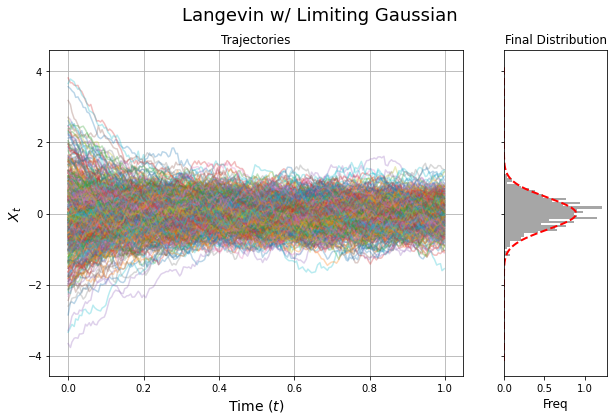

In [8]:
true_density = Gaussian(
    mean = torch.tensor([0.0]), 
    cov = 0.2 * torch.eye(1)
)
score = lambda x, _: true_density.score(x)
sde = LangevinDynamics(
    score=score, 
    noise_scheduler=inference.scheduler.Sigmoid(start=2.0, end=0.0),
)
simulator = EulerMaruyamaSimulator(sde = sde)

# Simulator Settings
num_trials = 500
num_steps = 10000
tf = 20.0

x0 = torch.randn((num_trials,1))
ts = torch.linspace(0, tf, num_steps)

# Visualization
plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
plt.suptitle('Langevin w/ Limiting Gaussian', fontsize=18)
plt.show()

In [ ]:
from ipywidgets import interact, FloatSlider

def run_sim(mean1, mean2, cov1, cov2):
    means = torch.tensor([mean1, mean2]).unsqueeze(1)
    covs = torch.tensor([cov1, cov2]).unsqueeze(1).unsqueeze(1)
    weights = torch.tensor([0.5, 0.5])

    true_density = GaussianMixture(means=means, covs=covs, weights=weights)
    score = lambda x, _: true_density.score(x)
    sde = LangevinDynamics(score=score, noise_scheduler=inference.scheduler.Sigmoid(start=5.0, end=0.01, steepness=0.6))
    simulator = EulerMaruyamaSimulator(sde=sde)

    num_samples = 500
    num_steps = 1500
    tf = 50
    x0 = torch.randn((num_samples, 1))
    ts = torch.linspace(0, tf, num_steps)

    plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, true_density=true_density)
    plt.suptitle('Langevin w/ Limiting Gaussian Mixture', fontsize=18)
    plt.show()

interact(
    run_sim,
    mean1=FloatSlider(value=-5.0, min=-10.0, max=0.0, step=0.5, description="mean1"),
    mean2=FloatSlider(value=5.0, min=0.0, max=10.0, step=0.5, description="mean2"),
    cov1=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description="cov1"),
    cov2=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description="cov2")
)

interactive(children=(FloatSlider(value=-5.0, description='mean1', max=0.0, min=-10.0, step=0.5), FloatSlider(…

<function __main__.run_sim(mean1, mean2, cov1, cov2)>